In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

import joblib


## 2. Display Settings

In [2]:
#TO get all columns
pd.set_option("display.max_columns",None)

In [3]:
#sklearn by default gives numpy but to get data pandas Dataframe
sklearn.set_config(transform_output="default")

## 3.Get Data

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
val_df = pd.read_csv("data/val.csv")

### 3.1 Split the Data

In [5]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [6]:
X_train,y_train = split_data(train_df)
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [7]:
X_val,y_val = split_data(val_df)

In [8]:
X_test,y_test = split_data(test_df)

## 4. Data PreProcessing

In [9]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          200 non-null    object 
 1   date_of_journey  200 non-null    object 
 2   source           200 non-null    object 
 3   destination      200 non-null    object 
 4   dep_time         200 non-null    object 
 5   arrival_time     200 non-null    object 
 6   duration         200 non-null    int64  
 7   total_stops      200 non-null    float64
 8   additional_info  200 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 14.2+ KB


In [10]:
dt_cols = ["date_of_journey","dep_time","arrival_time"]

num_cols = ["duration","total_stops"]

cat_cols = [col for col in X_train.columns if(col not in dt_cols) and (col not in num_cols)]

In [11]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

### Pipeline

In [12]:
num_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transformer = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy="most_frequent")),
         ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
    ])

doj_transformer = Pipeline(
    steps = [
        ("imputer",SimpleImputer(strategy="most_frequent")),
        ("extractor",DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"],format="mixed")),
        ("sclaer",StandardScaler())
    ]
)

time_transformer = Pipeline(
    steps = [
        ("imputer",SimpleImputer(strategy="most_frequent")),
        ("extractor",DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
        ("sclaer",StandardScaler())
    ]
)

In [13]:
preprocessor = ColumnTransformer(
    [
        ("num",num_transformer,num_cols),
        ("cat",cat_transformer,cat_cols),
        ("doj",doj_transformer,["date_of_journey"]),
        ("time",time_transformer,["dep_time","arrival_time"])
    ]
)

In [14]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

## 5. Model Selection

In [15]:
algorithms={
    "Linear Regression" : LinearRegression(),
    "Support Vector Machine" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators=10),
    "XG Boost" : XGBRegressor(n_estimators=10)
}

In [16]:
data = pd.concat([train_df,val_df],axis=0)
data
x_data,y_data = split_data(data)
y_data

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
155     4098
156    12475
157    10197
158    26890
159     4990
Name: price, Length: 800, dtype: int64

In [17]:
# def plot_curves(sizes ,mean_scores ,std_scores,ax):
#     ax.plot(
#     sizes,
#     mean_scores,
#     marke="o",
#     label,
#     )
    
#     ax.fillbetween(
#     x=sizes,
#     y1 = mean_scores - std_scores,
#     y2 = mean_scores + std_scores,
#     alpha=0.5,
#     )
def plot_curves(sizes, mean_scores, std_scores,label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )
    
    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5,
    )


In [18]:
def plot_learning_curves(name,algorithm,figsize=(12,8)):
    model = Pipeline(
        steps=[
            ("preprocessing",preprocessor),
            ("alg",algorithm),
        ]
    )

    train_sizes ,train_scores, test_scores = learning_curve(
        estimator=model,
        X=x_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )
    
    mean_train_scores = np.mean(train_scores,axis=1)
    std_train_scores = np.std(train_scores,axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores =  np.mean(test_scores,axis=1)
    std_test_scores = np.std(test_scores,axis=1)
    test_score  = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"    
    
    fig,ax = plt.subplots(figsize=figsize)

    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training set size",ylabel="R-Squared Value",title=name)

    ax.legend(loc="lower right")

    plt.show()

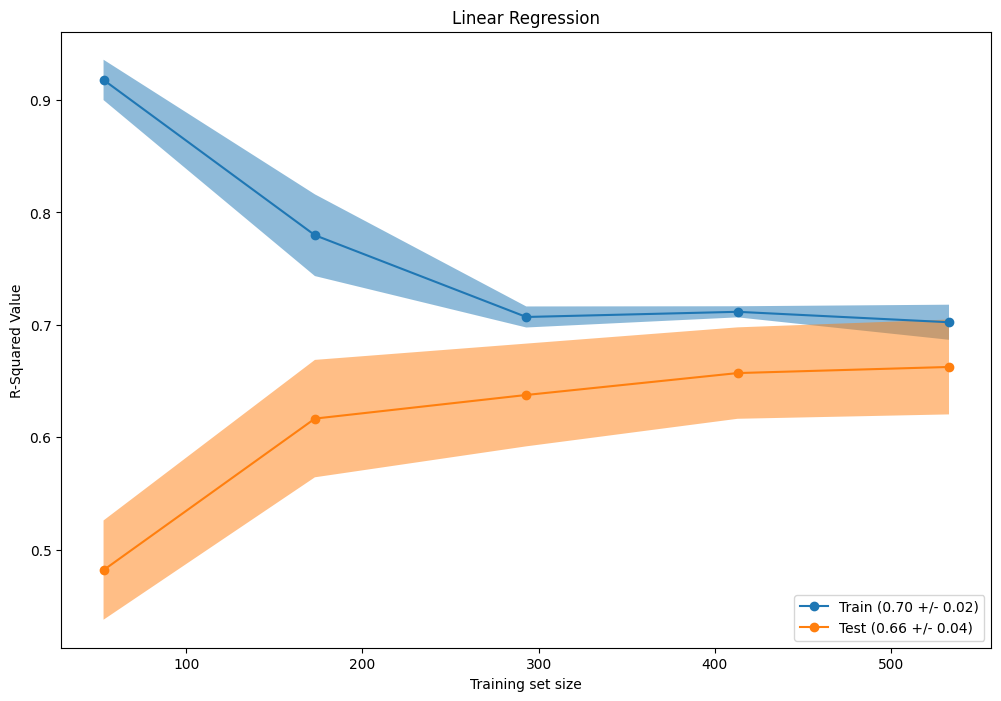

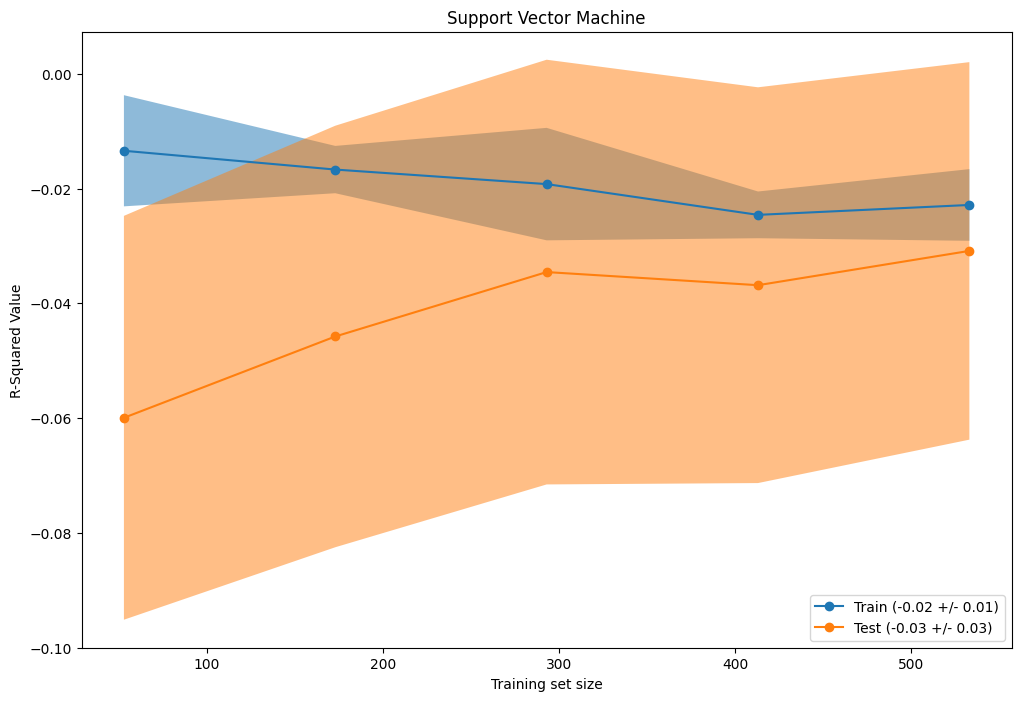

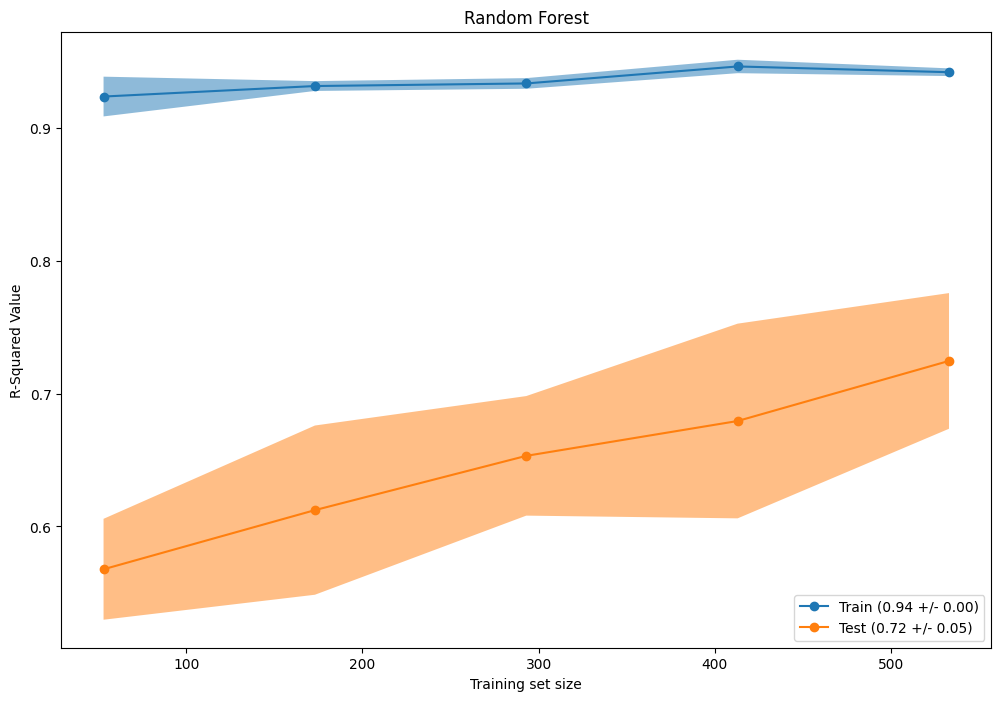

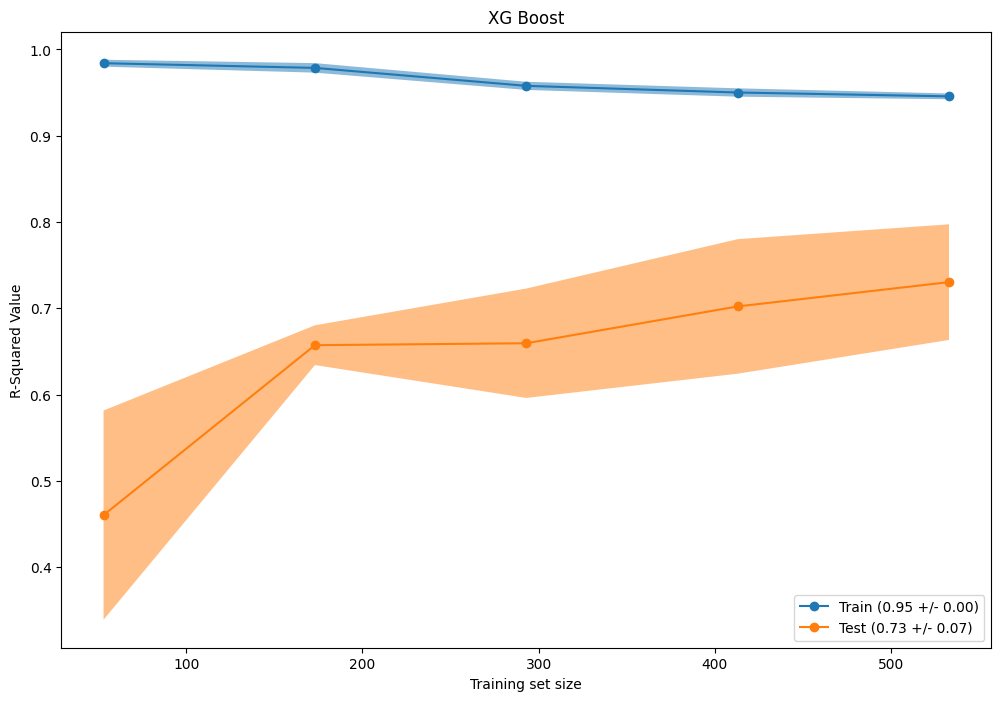

In [19]:
for name, alg in algorithms.items():
    plot_learning_curves(name,alg)

## 6. Model Training

In [20]:
model = Pipeline(
    steps = [
        ("pre",preprocessor),
        ("rf",RandomForestRegressor(n_estimators=10))
    ]
)

In [21]:
model.fit(x_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('sclaer',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('sclaer',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7. Model Evalutation

In [22]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)
print(f"R2 Score on training data is {evaluate_model(x_data,y_data)}")    

R2 Score on training data is 0.9616789914170026


In [23]:
print(f"R2 Score on training data is {evaluate_model(X_test,y_test)}")  

R2 Score on training data is 0.6065715952369215


 ## 8. Model Persistent

In [24]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [25]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('sclaer',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('sclaer',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [26]:
y_pred =  saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.6065715952369215

In [27]:
import feature_engine
print(feature_engine.__version__)


1.8.0
